<a href="https://colab.research.google.com/github/diyamanapetty/PRODIGY_ML_04/blob/main/Task_04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
import numpy as np
import cv2

In [24]:
import kagglehub
path = kagglehub.dataset_download("gti-upm/leapgestrecog")
print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/gti-upm/leapgestrecog/versions/1


In [25]:
def load_data(image_paths, label_mapping, image_size=(64, 64)):
    X, y = [], []
    for img_path in image_paths:
        # Extract folder name to determine the label
        folder_name = os.path.basename(os.path.dirname(img_path))
        if folder_name in label_mapping:
            label = label_mapping[folder_name]
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                print(f"Failed to read image: {img_path}")
                continue
            img = cv2.resize(img, image_size)
            X.append(img)
            y.append(label)
    X = np.array(X)
    y = np.array(y)
    X = X / 255.0  # Normalize
    return X, y

In [26]:
label_mapping = {
    "01_palm": 0,
    "02_l": 1,
    "03_fist": 2,
    "04_fist_moved": 3,
    "05_thumb": 4,
    "06_index": 5,
    "07_ok": 6,
    "08_palm_moved": 7,
    "09_c": 8,
    "10_down": 9,
}

In [27]:
X, y = load_data(valid_images, label_mapping)
print(f"Data Loaded. Shapes -> X: {X.shape}, y: {y.shape}")

Data Loaded. Shapes -> X: (20000, 64, 64), y: (20000,)


In [28]:
print("Feature shape:", X.shape)
print("Labels shape:", y.shape)

import collections
print("Class distribution:", collections.Counter(y))

Feature shape: (20000, 64, 64)
Labels shape: (20000,)
Class distribution: Counter({6: 2000, 4: 2000, 3: 2000, 2: 2000, 5: 2000, 8: 2000, 7: 2000, 9: 2000, 1: 2000, 0: 2000})


In [29]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

print(f"Training Set: {X_train.shape}, Validation Set: {X_val.shape}, Test Set: {X_test.shape}")

Training Set: (12800, 64, 64), Validation Set: (3200, 64, 64), Test Set: (4000, 64, 64)


In [36]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers

def create_model(input_shape=(64, 64, 1)):
    model = models.Sequential([
        layers.InputLayer(input_shape=input_shape),

        layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)),
        layers.MaxPooling2D((2, 2)),

        layers.Flatten(),

        layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
        layers.Dropout(0.5),  # Dropout layer to avoid overfitting
        layers.Dense(10, activation='softmax')
    ])

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

model = create_model()
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 64, 64, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 32, 32, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │       1,048,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,142,666 (4.36 MB)

 Trainable params: 1,142,666 (4.36 MB)

 Non-trainable params: 0 (0.00 B)

In [32]:
X_train = X_train.reshape(-1, 64, 64, 1)
X_val = X_val.reshape(-1, 64, 64, 1)
X_test = X_test.reshape(-1, 64, 64, 1)

print(f"X_train shape: {X_train.shape}, X_val shape: {X_val.shape}, X_test shape: {X_test.shape}")

X_train shape: (12800, 64, 64, 1), X_val shape: (3200, 64, 64, 1), X_test shape: (4000, 64, 64, 1)


In [41]:
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 113s 282ms/step - accuracy: 0.4345 - loss: 1.7071 - val_accuracy: 0.8772 - val_loss: 0.7486
Epoch 2/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 136s 268ms/step - accuracy: 0.7509 - loss: 0.9916 - val_accuracy: 0.9191 - val_loss: 0.6146
Epoch 3/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 105s 263ms/step - accuracy: 0.8386 - loss: 0.7941 - val_accuracy: 0.9787 - val_loss: 0.4625
Epoch 4/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 144s 269ms/step - accuracy: 0.8783 - loss: 0.6730 - val_accuracy: 0.9747 - val_loss: 0.4488
Epoch 5/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 106s 265ms/step - accuracy: 0.8983 - loss: 0.6248 - val_accuracy: 0.9894 - val_loss: 0.4037
Epoch 6/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 110s 274ms/step - accuracy: 0.9096 - loss: 0.5997 - val_accuracy: 0.9866 - val_loss: 0.3871
Epoch 7/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 139s 267ms/step - accuracy: 0.9271 - loss: 0.5346 - val_accuracy: 0.9909 - val_loss: 0.3573
Epoch 8/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 107s 268ms/step - accuracy: 0.9246 -

In [42]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 79ms/step - accuracy: 0.9874 - loss: 0.3410
Test Loss: 0.34182146191596985, Test Accuracy: 0.987500011920929


In [43]:
import numpy as np
import matplotlib.pyplot as plt

test_sample_index = 0
test_image = X_test[test_sample_index]
true_label = y_test[test_sample_index]

predictions = model.predict(np.expand_dims(test_image, axis=0))
predicted_class = np.argmax(predictions, axis=-1)[0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


In [48]:
true_label_name = list(label_mapping.keys())[list(label_mapping.values()).index(true_label)]
predicted_label_name = list(label_mapping.keys())[list(label_mapping.values()).index(predicted_class)]
prediction_probability = predictions[0][predicted_class]

In [49]:
print(f"True Label: {true_label_name}")
print(f"Predicted Label: {predicted_label_name}")
print(f"Prediction Probability: {prediction_probability:.4f}")

True Label: 07_ok
Predicted Label: 07_ok
Prediction Probability: 0.9872


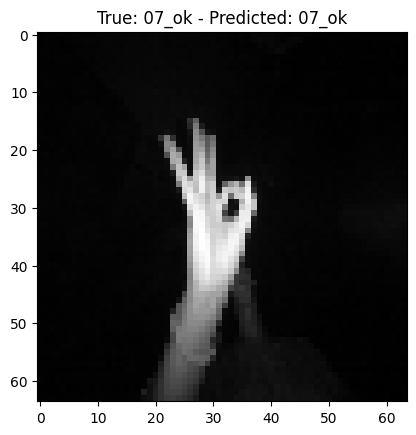

In [50]:
plt.imshow(test_image.squeeze(), cmap='gray')
plt.title(f"True: {true_label_name} - Predicted: {predicted_label_name}")
plt.show()